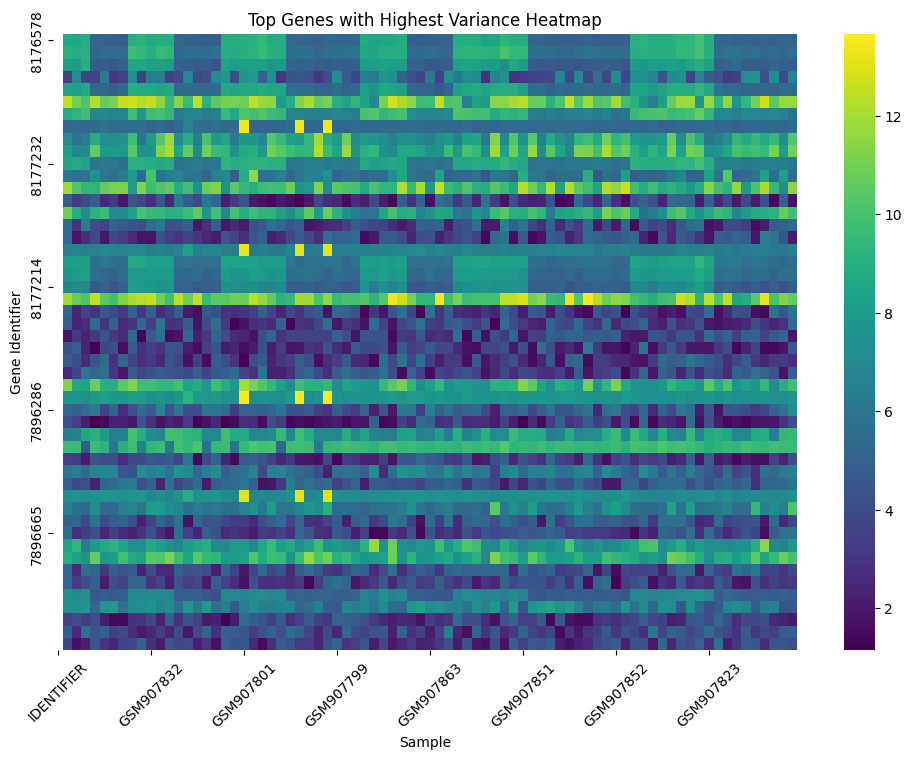

Accuracy: 0.688
Classification Report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       1.00      0.44      0.62         9

    accuracy                           0.69        16
   macro avg       0.79      0.72      0.68        16
weighted avg       0.82      0.69      0.67        16

Top 15 Important Genes based on Random Forest:
ID_REF
8134463    0.022199
7948167    0.020950
7964722    0.016195
8148049    0.014057
8179399    0.013071
8169699    0.012348
8117034    0.010889
8154223    0.010751
7916112    0.010297
7896265    0.010212
7976814    0.009959
8179481    0.009857
7892732    0.009466
8059708    0.008639
8059551    0.007805
dtype: float64
SVM Accuracy: 0.438
Classification Report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         9

    accuracy                           0.44        16
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2]:
import os
if not os.path.exists('GDS4758.soft.gz'):
    # fetch the microarray SOFT file from NCBI GEO
    !wget -q -O GDS4758.soft.gz \
      https://ftp.ncbi.nlm.nih.gov/geo/datasets/GDS4nnn/GDS4758/soft/GDS4758.soft.gz

# ───────────────────────────────────────────────────────────────
# SECTION 1: Gene-expression
# ───────────────────────────────────────────────────────────────
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

#Fix file path if needed
df = pd.read_csv(
    'GDS4758.soft.gz',
    skiprows=141,
    sep='\t',
    skipfooter=1,
    engine='python'         # ← enable skipfooter
)


# Manually enetered where and status of the sample from the .soft file
values = [
    "AD_HI", "AD_HI", "AD_HI", "AD_HI", "AD_HI", "AD_HI", "AD_HI",
    "AD_TC", "AD_TC", "AD_TC", "AD_TC", "AD_TC", "AD_TC", "AD_TC", "AD_TC", "AD_TC", "AD_TC",
    "AD_FC", "AD_FC", "AD_FC", "AD_FC", "AD_FC", "AD_FC", "AD_FC", "AD_FC", "AD_FC", "AD_FC",
    "AD_FC", "AD_FC", "AD_FC", "AD_FC", "AD_FC",
    "non-AD_HI", "non-AD_HI", "non-AD_HI", "non-AD_HI", "non-AD_HI", "non-AD_HI", "non-AD_HI", "non-AD_HI", "non-AD_HI", "non-AD_HI",
    "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC",
    "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC", "non-AD_TC",
    "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC",
    "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC", "non-AD_FC"
]

#Format the new status/location row
new_row = ["AD_Status/Location", "AD_Status/Location"] + values

new_row += [None] * (len(df.columns) - len(new_row))

df.loc[len(df)] = new_row

# Clean the data for this df
ad_status = df.iloc[-1]          # <--- keep this as strings for later
df = df.drop(df.index[-1])

df.set_index("ID_REF", inplace=True)

df = df.apply(pd.to_numeric, errors='coerce')

# Calculate variance for each gene
gene_variance = df.var(axis=1)

# Select top 50/800 genes based on variance
top_50_genes = gene_variance.nlargest(50).index
df_top_genes = df.loc[top_50_genes]

top_800_genes = gene_variance.nlargest(800).index
df_top800_genes = df.loc[top_800_genes]

# Visualizations
# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_top_genes, cmap="viridis", xticklabels=10, yticklabels=10)
plt.title('Top Genes with Highest Variance Heatmap')
plt.xlabel('Sample')
plt.xticks(rotation=45)
plt.ylabel('Gene Identifier')
plt.show()

# Extract AD status
ad_strings = ad_status                                 # <--- preserve originals
ad = ad_strings.str.split("_").str[0]
ad_status = ad.map(lambda x: 1 if x == "AD" else 0)
ad_status = ad_status.drop(columns=['IDENTIFIER'])
ad_status = ad_status.iloc[2:]

# Drop AD status row from df_top_genes
df_top_genes = df_top800_genes.drop(df_top800_genes.index[-1])
df_top_genes = df_top_genes.drop(columns=['IDENTIFIER'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(ad_status)
X = df_top_genes.T
# Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
feature_importance = rf_classifier.feature_importances_
top_genes = X.columns
important_features = pd.Series(feature_importance, index=top_genes).sort_values(ascending=False)

print("Top 15 Important Genes based on Random Forest:")
print(important_features.head(15))

svm_classifier = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_classifier.fit(X_train, y_train)

# Predict
y_pred = svm_classifier.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))



# New Section

<ipython-input-5-3ab290c05096>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  oasis_df[col].fillna(oasis_df[col].median(), inplace=True)


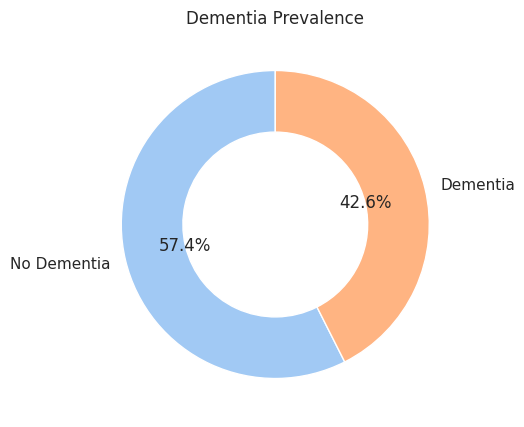

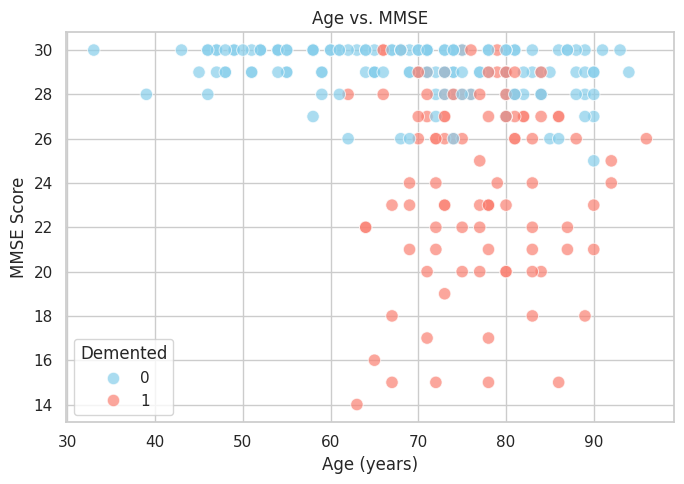

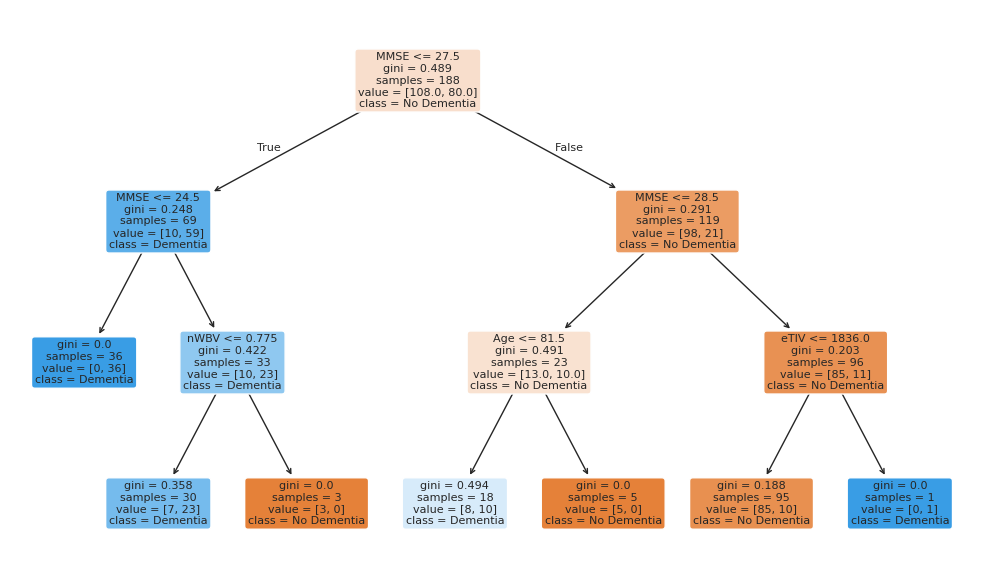

Decision Tree Accuracy: 0.787
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        27
           1       0.75      0.75      0.75        20

    accuracy                           0.79        47
   macro avg       0.78      0.78      0.78        47
weighted avg       0.79      0.79      0.79        47



In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

#OASIS dataset sector of loading
oasis_df = pd.read_csv('oasis_cross-sectional.csv').dropna(subset=['CDR'])
oasis_df['Demented'] = (oasis_df['CDR'] > 0).astype(int)
#Here we are setting True if CDR>0

for col in ['Educ', 'SES', 'MMSE']:
  # remember to inpute missing values
    oasis_df[col].fillna(oasis_df[col].median(), inplace=True)

# Encode categorical features
oasis_df['M_F']    = LabelEncoder().fit_transform(oasis_df['M/F'])
oasis_df['Handed'] = LabelEncoder().fit_transform(oasis_df['Hand'])
#Similarly for Handed, turning “L”/“R” into 0/1



#dementia prevalence (donut chart)
sns.set(style='whitegrid')
plt.figure(figsize=(5,5))
oasis_df['Demented'].value_counts().plot.pie(
  #counting how many 0s vs 1s, then make a pie chart with that series.

    labels=['No Dementia','Dementia'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width':0.4,'edgecolor':'w'},
    colors=sns.color_palette('pastel')[0:2]
)
plt.title('Dementia Prevalence')
plt.ylabel('')
plt.savefig('oasis_dementia_donut.png', dpi=150)
plt.show()

#Age vs. MMSE scatter plot
plt.figure(figsize=(7,5))
sns.scatterplot(
    x='Age', y='MMSE', hue='Demented',
    data=oasis_df,
    palette=['skyblue','salmon'], alpha=0.7, s=80
)
plt.title('Age vs. MMSE')
plt.xlabel('Age (years)')
plt.ylabel('MMSE Score')
plt.legend(title='Demented')
plt.tight_layout()
plt.savefig('age_vs_mmse.png', dpi=150)
plt.show()


features = ['M_F','Handed','Age','Educ','SES','MMSE','eTIV','nWBV','ASF']
X = oasis_df[features]

y = oasis_df['Demented']
# here is the prepping data for modeling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) #keep the same dementia/no-dementia ratio in both sets.

# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# visual and save the tree
plt.figure(figsize=(10,6))
plot_tree(
    dt,
    feature_names=features,
    class_names=['No Dementia','Dementia'],
    filled=True, rounded=True, fontsize=8
)
plt.tight_layout()
plt.savefig('decision_tree.png', dpi=150)
plt.show()

# Evaluate model ML
y_pred = dt.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, zero_division=0))